In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import cv2
import os
from PIL import Image


import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models


In [2]:
!nvidia-smi

Tue Apr 20 14:15:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
data_dir = '/content/drive/MyDrive/1. Full Projects/(Complete) Transfer Learning Intel Image Classification/data'
train_dir = '/seg_train'
test_dir = '/seg_test'
pred_dir = '/seg_pred'
# List out pred files to load for single inference later
pred_files = [os.path.join(data_dir+pred_dir, f) for f in os.listdir(data_dir+pred_dir)]

In [25]:
cat_counts = {}
for cat in os.listdir(data_dir+train_dir):
    counts = len(os.listdir(os.path.join(data_dir+train_dir, cat)))
    cat_counts[cat] =counts
print(cat_counts)

{'glacier': 2404, 'forest': 2271, 'buildings': 2191, 'street': 2382, 'sea': 2274, 'mountain': 2512}


In [26]:
cat_counts = {}
for cat in os.listdir(data_dir+test_dir):
    counts = len(os.listdir(os.path.join(data_dir+test_dir, cat)))
    cat_counts[cat] =counts
print(cat_counts)

{'sea': 520, 'glacier': 553, 'mountain': 525, 'buildings': 437, 'street': 501, 'forest': 474}


In [27]:
outcomes = os.listdir(data_dir+train_dir)
classes = {k:v for k , v in enumerate(sorted(outcomes))}

classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [4]:
# Temporary transforms, dataset, and loader to compute the mean and std of the set
tmp_transforms = transforms.Compose([transforms.Resize((150, 150)),
                                     transforms.ToTensor()])

tmp_dataset = datasets.ImageFolder(root = data_dir+train_dir, transform = tmp_transforms)

tmp_loader = torch.utils.data.DataLoader(dataset = tmp_dataset, batch_size=512, shuffle=False)

In [5]:
# Compute mean and standard deviation
def get_mean_and_std(loader):
  # Tracking variable
  mean = 0.0
  std = 0.0
  total_images_count = 0
  # Extract image data from the loader
  for i, batch in enumerate(loader):
    images, _ = batch
    # Store the size of each deimension (b, c, w, h)
    image_count_in_batch = images.size(0)
    # Reshape to sum the image pixels
    images = images.view(image_count_in_batch, images.size(1), -1)

    # Accumulate the mean and std
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

    # Accumiate total image count
    total_images_count += image_count_in_batch
    # Print batch number and total image count
    print(f'Batch: {i} \tTotal Images Processed: {total_images_count} of 14034')

  # Divide accumilated mean and std by total count 
  mean /= total_images_count
  std /= total_images_count
  # Return values
  return mean, std


get_mean_and_std(tmp_loader)
#(tensor([0.4302, 0.4575, 0.4539]), tensor([0.2361, 0.2347, 0.2432]))

In [6]:
# RESENT MEAN & STD
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

In [7]:
# Step 1: Define the transforms and apply them to the datasets
train_transforms = transforms.Compose([transforms.Resize((150, 150)),
                                       transforms.RandomResizedCrop(150),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                                       ])



val_transforms = transforms.Compose([transforms.Resize((150, 150)),
                                     transforms.CenterCrop(150),
                                     transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
                                     ])


tmp_data = datasets.ImageFolder(data_dir+train_dir, transform=train_transforms)
# len(tmp_data): 14034
train_data, val_data = random_split(tmp_data, [10000, 4034], generator=torch.Generator().manual_seed(42))
test_data = datasets.ImageFolder(data_dir+test_dir, transform=val_transforms)


# Step 2: Define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [9]:
def show_transformed(loader):
    plt.figure(figsize=(60,60))
    # for images, labels in one batch of loader:
    batch = next(iter(loader))
    images, labels = batch
    grid = make_grid(images, nrow = 10)
    print(('Labels', labels))
    plt.imshow(np.transpose(grid, (1 ,2, 0)))
    plt.show()


show_transformed(train_loader)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [11]:
%%capture
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
  param.required_grad = False

features = resnet.fc.in_features


# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(features, 512)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(0.05)),
                                        ('fc2', nn.Linear(512, 6)),
                                        ]))

# ('output', nn.LogSoftmax(dim=1))
resnet.classifier = classifier

resnet.to(device)

In [12]:
# Step : Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
# pass the optimizer to the appended classifier layer
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001)
# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.05)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=10, epochs=20)

In [14]:
epochs = 20


tr_losses = []
avg_epoch_tr_loss = []
tr_accuracy = []


val_losses = []
avg_epoch_val_loss = []
val_accuracy = []
val_loss_min = np.Inf


resnet.train()
for epoch in range(epochs):
  for i, batch in enumerate(train_loader):
    # Pull the data and labels from the batch
    data, label = batch
    # If available push data and label to GPU
    if train_on_gpu:
      data, label = data.to(device), label.to(device)
    # Clear the gradient
    optimizer.zero_grad()
    # Compute the logit
    logit = resnet(data)
    # Compte loss
    loss = criterion(logit, label)
    # Backpropagate the gradients (accumulte the partial derivatives of loss)
    loss.backward()
    # Apply the updates to the optimizer step in the opposite direction to the gradient
    optimizer.step()
    # Store the losses of each batch
    # loss.item() seperates the loss from comp graph
    tr_losses.append(loss.item())
    # Detach and store the average accuracy of each batch
    tr_accuracy.append(label.eq(logit.argmax(dim=1)).float().mean())
    # Print the rolling batch training loss every 20 batches
    if i % 40 == 0:
      print(f'Batch No: {i} \tAverage Training Batch Loss: {torch.tensor(tr_losses).mean():.2f}')
  # Print the average loss for each epoch
  print(f'\nEpoch No: {epoch + 1},Training Loss: {torch.tensor(tr_losses).mean():.2f}')
  # Print the average accuracy for each epoch
  print(f'Epoch No: {epoch + 1}, Training Accuracy: {torch.tensor(tr_accuracy).mean():.2f}\n')
  # Store the avg epoch loss for plotting
  avg_epoch_tr_loss.append(torch.tensor(tr_losses).mean())


  resnet.eval()
  for i, batch in enumerate(val_loader):
    # Pull the data and labels from the batch
    data, label = batch
    # If available push data and label to GPU
    if train_on_gpu:
      data, label = data.to(device), label.to(device)
    # Compute the logits without computing the gradients
    with torch.no_grad():
      logit = resnet(data)
    # Compte loss
    loss = criterion(logit, label)
    # Store test loss
    val_losses.append(loss.item())
    # Store the accuracy for each batch
    val_accuracy.append(label.eq(logit.argmax(dim=1)).float().mean())
    if i % 20 == 0:
      print(f'Batch No: {i} \tAverage Val Batch Loss: {torch.tensor(val_losses).mean():.2f}')
  # Print the average loss for each epoch
  print(f'\nEpoch No: {epoch + 1}, Epoch Val Loss: {torch.tensor(val_losses).mean():.2f}')
  # Print the average accuracy for each epoch    
  print(f'Epoch No: {epoch + 1}, Epoch Val Accuracy: {torch.tensor(val_accuracy).mean():.2f}\n')
  # Store the avg epoch loss for plotting
  avg_epoch_val_loss.append(torch.tensor(val_losses).mean())

  # Checpoininting the model using val loss threshold
  if torch.tensor(val_losses).float().mean() <= val_loss_min:
    print("Epoch Val Loss Decreased... Saving model")
    # save current model
    torch.save(resnet.state_dict(), '/content/drive/MyDrive/1. Full Projects/(Complete) Transfer Learning Intel Image Classification/model_state.pt')
    val_loss_min = torch.tensor(val_losses).mean()
  # Step the scheduler for the next epoch
  scheduler.step()
  # Print the updated learning rate
  print('Learning Rate Set To: {:.10f}'.format(optimizer.state_dict()['param_groups'][0]['lr']),'\n')

Batch No: 0 	Average Training Batch Loss: 7.93
Batch No: 40 	Average Training Batch Loss: 4.66
Batch No: 80 	Average Training Batch Loss: 3.21
Batch No: 120 	Average Training Batch Loss: 2.49

Epoch No: 1,Training Loss: 2.12
Epoch No: 1, Training Accuracy: 0.57

Batch No: 0 	Average Val Batch Loss: 0.90
Batch No: 20 	Average Val Batch Loss: 0.83
Batch No: 40 	Average Val Batch Loss: 0.79
Batch No: 60 	Average Val Batch Loss: 0.78

Epoch No: 1, Epoch Val Loss: 0.79
Epoch No: 1, Epoch Val Accuracy: 0.78

Epoch Val Loss Decreased... Saving model
Learning Rate Set To: 0.00100 

Batch No: 0 	Average Training Batch Loss: 2.11
Batch No: 40 	Average Training Batch Loss: 1.81
Batch No: 80 	Average Training Batch Loss: 1.61
Batch No: 120 	Average Training Batch Loss: 1.46

Epoch No: 2,Training Loss: 1.34
Epoch No: 2, Training Accuracy: 0.69

Batch No: 0 	Average Val Batch Loss: 0.79
Batch No: 20 	Average Val Batch Loss: 0.76
Batch No: 40 	Average Val Batch Loss: 0.73
Batch No: 60 	Average Val Ba

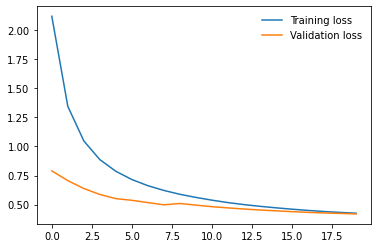

In [15]:
# Plot the average epoch losses 
plt.plot(avg_epoch_tr_loss, label='Training loss')
plt.plot(avg_epoch_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()


In [16]:
# Load resnet state dict
resnet.load_state_dict(torch.load('/content/drive/MyDrive/1. Full Projects/(Complete) Transfer Learning Intel Image Classification/model_state.pt'))
resnet.eval()
resnet = resnet.cuda()

In [17]:
def test_model(model, data):
  te_accuracy =[]
  for i, batch in enumerate(test_loader):
      # Pull the data and labels from the batch
      data, label = batch
      # If available push data and label to GPU
      if train_on_gpu:
        data, label = data.to(device), label.to(device)
      # Compute the logits without computing the gradients
      with torch.no_grad():
        logit = resnet(data)
      # Store the accuracy for each batch
      te_accuracy.append(label.eq(logit.argmax(dim=1)).float().mean())
      if i % 20 == 0 and not i == 1:
        print(f'Batch No. {i}\tAverage Test Batch Accuracy: {torch.tensor(te_accuracy).mean():.3f}')

  print(f'Test Accuracy: {torch.tensor(te_accuracy).mean():.3f}\n')


In [18]:
test_model(resnet, test_loader)

Batch No. 0	Average Test Batch Accuracy: 0.953
Batch No. 20	Average Test Batch Accuracy: 0.917
Batch No. 40	Average Test Batch Accuracy: 0.915
Test Accuracy: 0.906



In [23]:
def predictions(image):
    # pil_img = Image.open(image)
    # transform images
    transform = val_transforms(image)
    # add extra dimension in place of batch size
    img = transform.unsqueeze(0).cuda() 
    # push to gpu
    gpu_img = img.to(device)
    # make prediction
    output = resnet(gpu_img)
    # convert image to numpy format in cpu and snatching max prediction score class index
    # _, index = torch.max(output.data, 1)
    index = output.data.cpu().numpy().argmax()    
    return index



In [24]:
# use the class dict created earlier to pull the label as title
resnet.eval()
plt.figure(figsize=(20,20))
for i, images in enumerate(pred_files):
    # just want 25 images to print
    if i > 24:
      break
    # Using pil to open the image
    img = Image.open(images)
    # Calling prediction function on image
    index = predictions(img)
    # Plotting
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.